In [16]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils import aperture_photometry, CircularAperture, CircularAnnulus



In [15]:
# Replace with the path to your FITS files directory
fits_directory = '/Users/wendymendoza/Desktop/Yan/2023-03-16'

In [17]:
# Coordinates of your target object and reference stars
target_coords = (2105.4637, 1745.8571)
reference_coords_list = [(1738.4472, 1928.3894), (1830.7047, 2965.5023)]

In [18]:
# Get a list of FITS files
fits_files = sorted(glob.glob(os.path.join(fits_directory, '*.fits')))


In [19]:
# Aperture and annulus radii for photometry
aperture_radius = 16
annulus_inner_radius = 28
annulus_outer_radius = 41 

time_array = []
flux_ratio_array = []

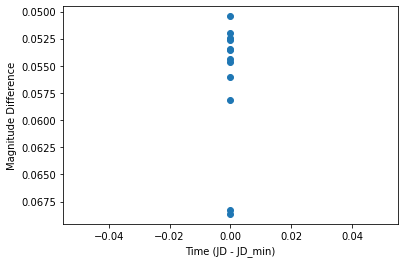

In [20]:
for file in fits_files:
    with fits.open(file) as hdulist:
        header = hdulist[0].header
        data = hdulist[0].data.astype(float)

        # Subtract the background
        mean, median, std = sigma_clipped_stats(data, sigma=3.0)
        data -= median

        # Define the target apertures and annuli
        target_aperture = CircularAperture(target_coords, r=aperture_radius)
        target_annulus = CircularAnnulus(target_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

        # Perform aperture photometry for the target object
        target_phot = aperture_photometry(data, [target_aperture, target_annulus])

        # Calculate the background-subtracted flux for the target object
        target_bkg_mean = target_phot['aperture_sum_1'] / target_annulus.area
        target_flux = target_phot['aperture_sum_0'] - target_bkg_mean * target_aperture.area

        # Calculate the magnitude difference for each reference star
        mag_diff_list = []

        for ref_coords in reference_coords_list:
            # Define the reference star apertures and annuli
            ref_aperture = CircularAperture(ref_coords, r=aperture_radius)
            ref_annulus = CircularAnnulus(ref_coords, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

            # Perform aperture photometry for the reference star
            ref_phot = aperture_photometry(data, [ref_aperture, ref_annulus])

            # Calculate the background-subtracted flux for the reference star
            ref_bkg_mean = ref_phot['aperture_sum_1'] / ref_annulus.area
            ref_flux = ref_phot['aperture_sum_0'] - ref_bkg_mean * ref_aperture.area

            # Calculate the magnitude difference
            mag_diff = -2.5 * np.log10(target_flux / ref_flux)
            mag_diff_list.append(mag_diff)

        # Calculate the average magnitude difference
        avg_mag_diff = np.mean(mag_diff_list)

        # Store the time and average magnitude difference
        time_array.append(Time(header['DATE-OBS']).jd)
        flux_ratio_array.append(avg_mag_diff)

# Normalize the time array
time_array = np.array(time_array) - min(time_array)

# Plot the light curve
plt.figure()
plt.plot(time_array, flux_ratio_array, 'o') 
plt.xlabel('Time (JD - JD_min)')
plt.ylabel('Magnitude Difference')
plt.gca().invert_yaxis()
plt.show()